In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile

In [2]:
BASE_PATH = './hubmap-kidney-segmentation/'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')

print(os.listdir(BASE_PATH))

['HuBMAP-20-dataset_information.csv', 'sample_submission.csv', 'test', 'train', 'train.csv']


### train.csv 
包含每个图像的唯一id，以及图像中对象的mask的RLE编码表示。

In [3]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

id                                           encoding
0  2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1  aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
2  cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
3  0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
4  e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
5  095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
6  54f2eec69  124601765 36 124632133 109 124662536 147 12469...
7  1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

### 样本数量

In [4]:
df_sub = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv"))
df_sub

id  predicted
0  b9a3865fc        NaN
1  b2dc8411c        NaN
2  26dc41664        NaN
3  c68fe75ea        NaN
4  afa5e8098        NaN

In [5]:
print(f"Number of train images: {df_train.shape[0]}")
print(f"Number of test images: {df_sub.shape[0]}")

Number of train images: 8
Number of test images: 5


### Train and test metadata
HuBMAP-20-dataset_information.csv包含有关每个图像的附加信息（包括匿名患者数据）。

In [6]:
df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)

image_file  width_pixels  height_pixels  \
8  b9a3865fc.tiff         40429          31295   
7  aaa6a05cc.tiff         13013          18484   
5  095bf7a1f.tiff         39000          38160   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
8   b9a3865fc-anatomical-structure.json               b9a3865fc.json   
7   aaa6a05cc-anatomical-structure.json               aaa6a05cc.json   
5   095bf7a1f-anatomical-structure.json               095bf7a1f.json   

   patient_number   race               ethnicity     sex  age  \
8           67347  White  Not Hispanic or Latino  Female   58   
7           65631  White  Not Hispanic or Latino  Female   73   
5           68250  White  Not Hispanic or Latino  Female   44   

   weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
8              59.0               160.0        23.0      Right   
7               NaN                 NaN         NaN       Left   
5              71.7               160.0        28.0      Right   

   percent_cortex  percent_medulla  
8              55               45  
7              75               25  
5              65               35

In [7]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_train[df_train["id"] == image_id]["encoding"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask




def read_test_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"test/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image


def plot_image_and_mask(image, mask, image_id):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()


def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    n_cols = 4
    n_rows = 4
    col_start = 0
    col_w = 2500
    row_start = 0
    row_w = 2500
    for i in range(n_cols):
        for j in range(n_rows):
            plt.subplot(n_cols, n_rows, n_rows * i + j + 1)
            sub_image = image[
                col_start + i * col_w : col_start + (i + 1) * col_w, 
                row_start + j * row_w : row_start + (j + 1) * row_w, 
                :
            ]
            sub_mask = mask[
                col_start + i * col_w : col_start + (i + 1) * col_w, 
                row_start + j * row_w : row_start + (j + 1) * row_w, 
            ]
            plt.imshow(sub_image)
            plt.imshow(sub_mask, cmap="hot", alpha=0.5)
            plt.axis("off")
    plt.show()

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap="hot")
    plt.axis("off")
    
    plt.show()

In [9]:
small_ids = [
    "0486052bb", "095bf7a1f", "1e2425f28", "2f6ecfcdf",
    "54f2eec69", "aaa6a05cc", "cb2d976f4", "e79de561c",
]
small_images = []
small_masks = []

for small_id in small_ids:
    tmp_image, tmp_mask = read_image(small_id, scale=20, verbose=0)
    small_images.append(tmp_image)
    small_masks.append(tmp_mask)

### Train images

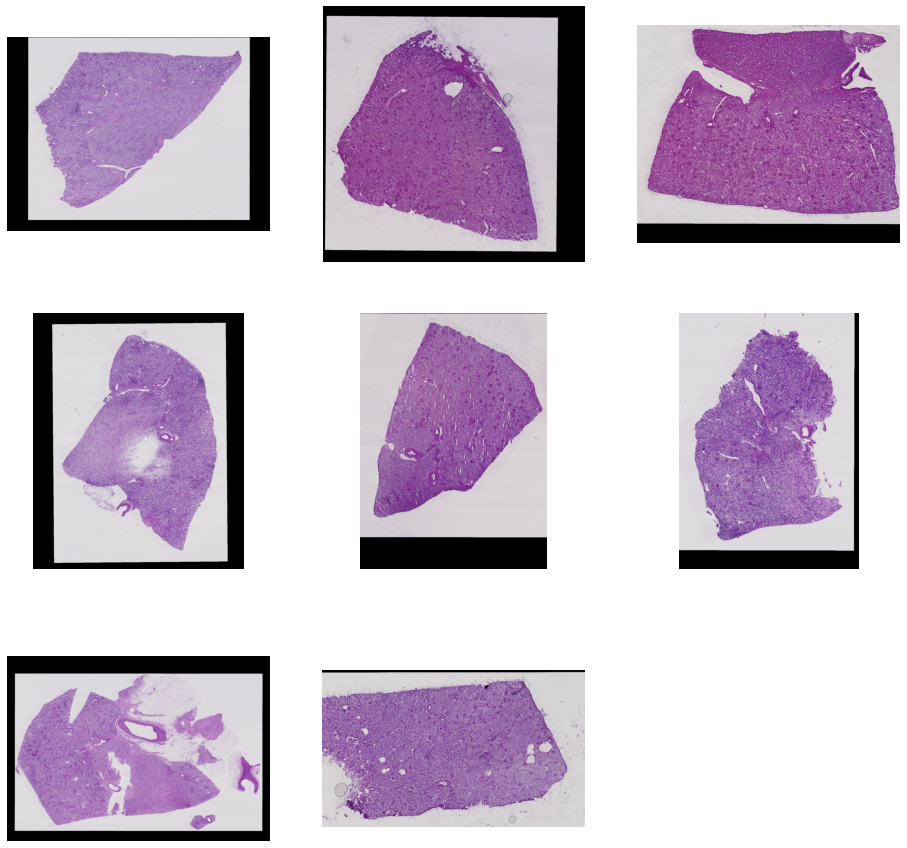

In [10]:
plt.figure(figsize=(16, 16))
for ind, (tmp_id, tmp_image) in enumerate(zip(small_ids, small_images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.axis("off")

### Train images + masks

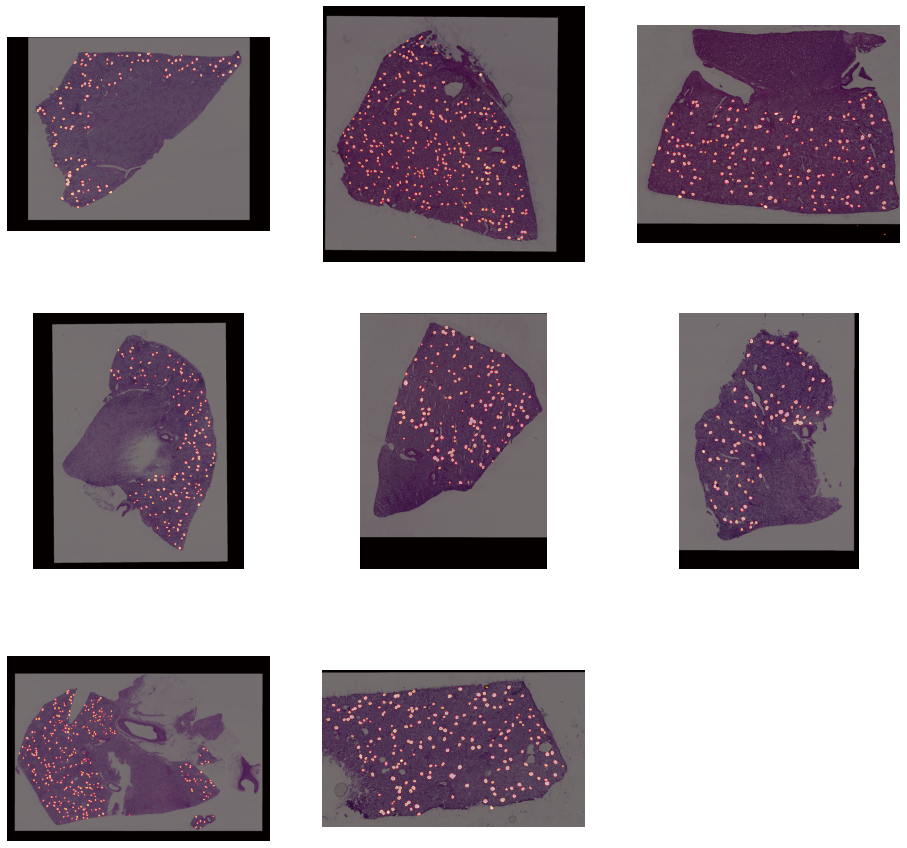

In [11]:
plt.figure(figsize=(16, 16))
for ind, (tmp_id, tmp_image, tmp_mask) in enumerate(zip(small_ids, small_images, small_masks)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.imshow(tmp_mask, cmap="hot", alpha=0.5)
    plt.axis("off")

### Test images

In [12]:
small_ids = [
    "26dc41664", "afa5e8098", "b2dc8411c", "b9a3865fc", "c68fe75ea",
]
small_images = []

for small_id in small_ids:
    tmp_image = read_test_image(small_id, scale=20, verbose=0)
    small_images.append(tmp_image)

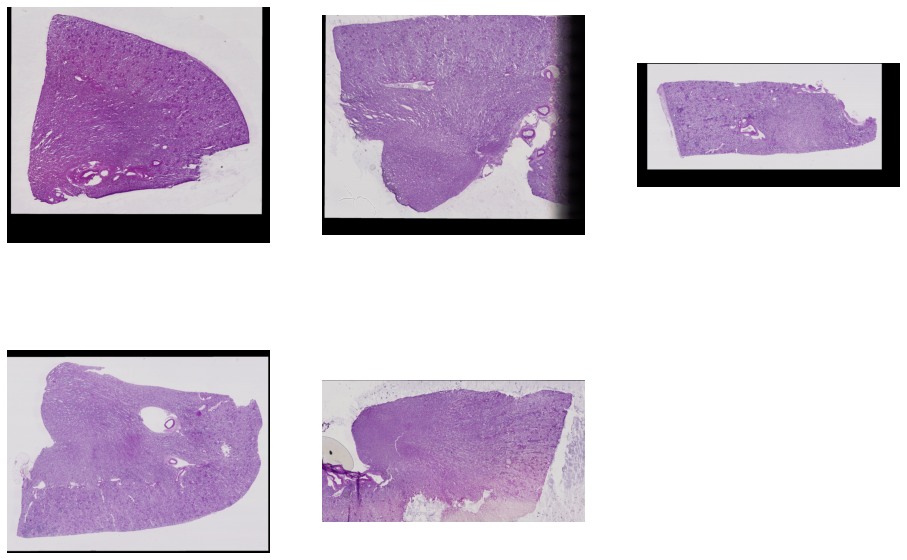

In [13]:
plt.figure(figsize=(16, 11))
for ind, (tmp_id, tmp_image) in enumerate(zip(small_ids, small_images)):
    plt.subplot(2, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.axis("off")

### 095bf7a1f

[095bf7a1f] Image shape: (38160, 39000, 3)
[095bf7a1f] Mask shape: (38160, 39000)
[095bf7a1f] Resized Image shape: (19080, 19500, 3)
[095bf7a1f] Resized Mask shape: (19080, 19500)


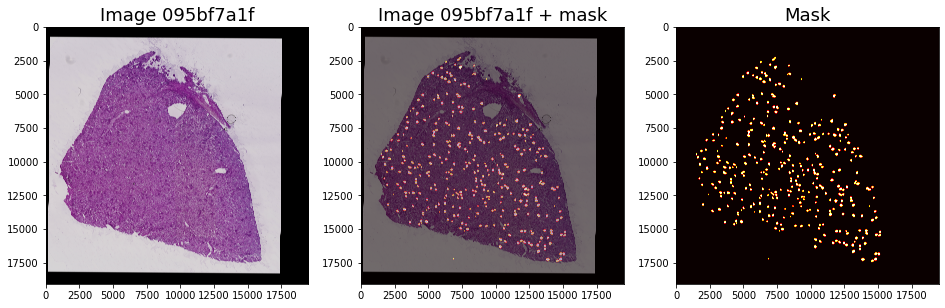

In [14]:
image_id = "095bf7a1f"
image, mask = read_image(image_id, scale=2)
plot_image_and_mask(image, mask, image_id)

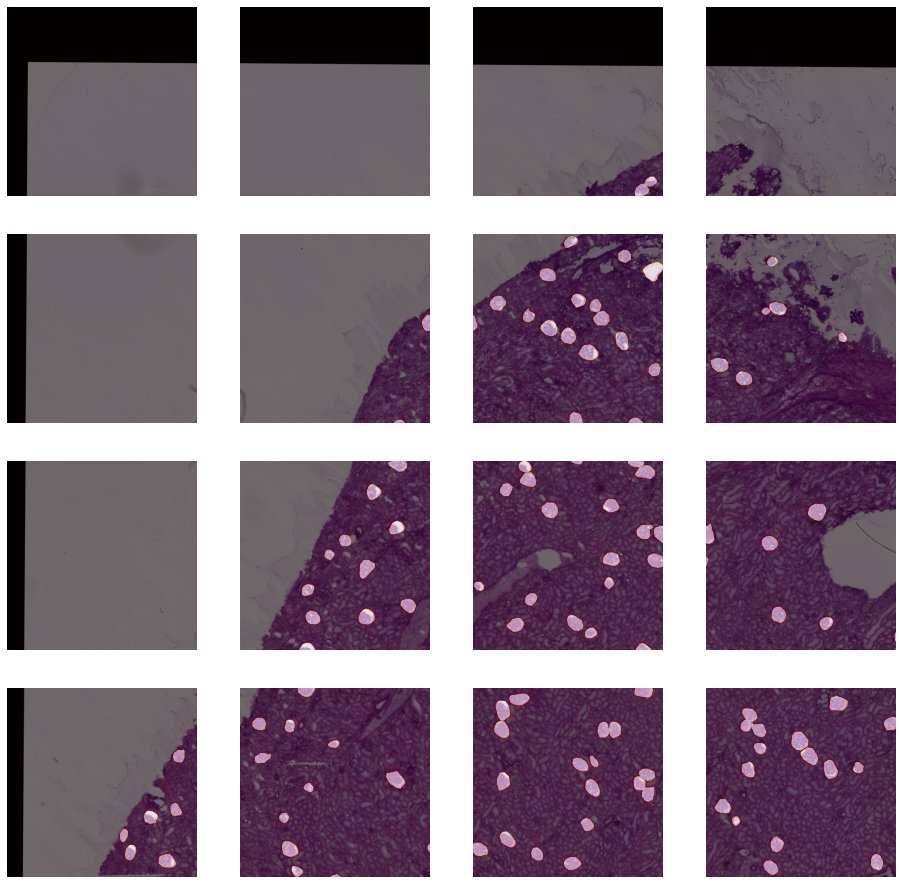

In [15]:
plot_grid_image_with_mask(image, mask)

### 1e2425f28

In [16]:
image_id = "1e2425f28"
image, mask = read_image(image_id, scale=2)
plot_image_and_mask(image, mask, image_id)

[1e2425f28] Image shape: (26780, 32220, 3)
[1e2425f28] Mask shape: (26780, 32220)
[1e2425f28] Resized Image shape: (13390, 16110, 3)
[1e2425f28] Resized Mask shape: (13390, 16110)


### 2f6ecfcdf

[2f6ecfcdf] Image shape: (31278, 25794, 3)
[2f6ecfcdf] Mask shape: (31278, 25794)
[2f6ecfcdf] Resized Image shape: (15639, 12897, 3)
[2f6ecfcdf] Resized Mask shape: (15639, 12897)


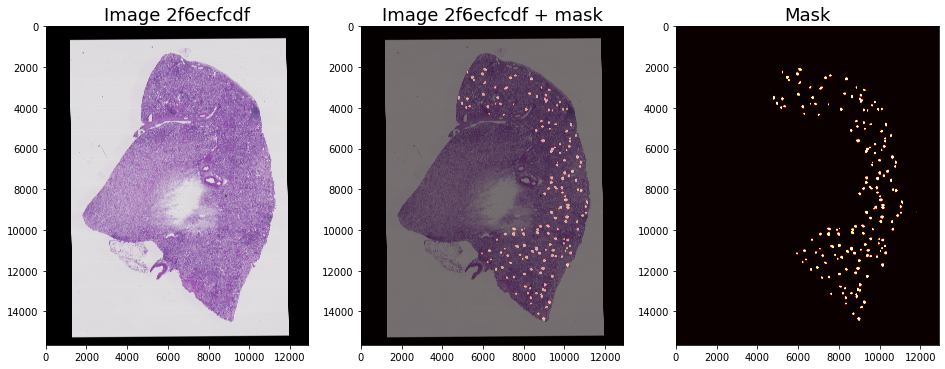

In [17]:
image_id = "2f6ecfcdf"
image, mask = read_image(image_id, scale=2)
plot_image_and_mask(image, mask, image_id)

### aaa6a05cc

[aaa6a05cc] Image shape: (18484, 13013, 3)
[aaa6a05cc] Mask shape: (18484, 13013)


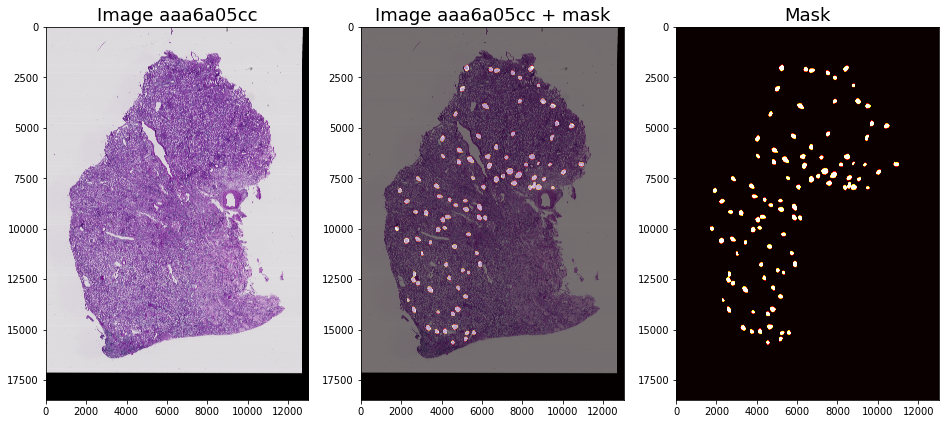

In [18]:
image_id = "aaa6a05cc"
image, mask = read_image(image_id)
plot_image_and_mask(image, mask, image_id)

### e79de561c

[e79de561c] Image shape: (16180, 27020, 3)
[e79de561c] Mask shape: (16180, 27020)


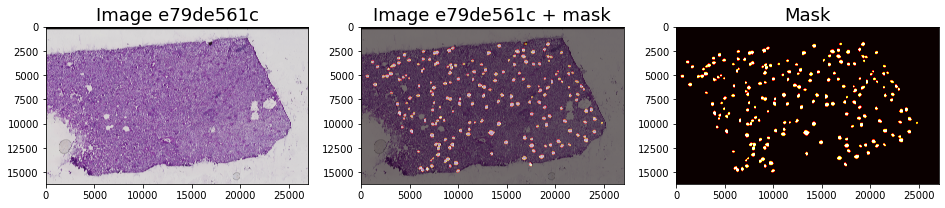

In [19]:
image_id = "e79de561c"
image, mask = read_image(image_id)
plot_image_and_mask(image, mask, image_id)

## Metadata Analysis

In [20]:
pd.read_json(
    os.path.join(BASE_PATH, "train/0486052bb-anatomical-structure.json")
)

type                    id  \
0  Feature  PathAnnotationObject   
1  Feature  PathAnnotationObject   

                                            geometry  \
0  {'type': 'Polygon', 'coordinates': [[[20606, 4...   
1  {'type': 'Polygon', 'coordinates': [[[30717, 1...   

                                          properties  
0  {'classification': {'name': 'Medulla', 'colorR...  
1  {'classification': {'name': 'Cortex', 'colorRG...

In [21]:
pd.read_json(
    os.path.join(BASE_PATH, "train/0486052bb.json")
)

type                    id  \
0    Feature  PathAnnotationObject   
1    Feature  PathAnnotationObject   
2    Feature  PathAnnotationObject   
3    Feature  PathAnnotationObject   
4    Feature  PathAnnotationObject   
..       ...                   ...   
121  Feature  PathAnnotationObject   
122  Feature  PathAnnotationObject   
123  Feature  PathAnnotationObject   
124  Feature  PathAnnotationObject   
125  Feature  PathAnnotationObject   

                                              geometry  \
0    {'type': 'Polygon', 'coordinates': [[[4747, 96...   
1    {'type': 'Polygon', 'coordinates': [[[6631, 67...   
2    {'type': 'Polygon', 'coordinates': [[[6287, 10...   
3    {'type': 'Polygon', 'coordinates': [[[6579, 13...   
4    {'type': 'Polygon', 'coordinates': [[[8779, 11...   
..                                                 ...   
121  {'type': 'Polygon', 'coordinates': [[[23073, 2...   
122  {'type': 'Polygon', 'coordinates': [[[20891, 5...   
123  {'type': 'Polygon', 'coordinates': [[[15277, 2...   
124  {'type': 'Polygon', 'coordinates': [[[7172, 85...   
125  {'type': 'Polygon', 'coordinates': [[[4139, 95...   

                                            properties  
0    {'classification': {'name': 'glomerulus', 'col...  
1    {'classification': {'name': 'glomerulus', 'col...  
2    {'classification': {'name': 'glomerulus', 'col...  
3    {'classification': {'name': 'glomerulus', 'col...  
4    {'classification': {'name': 'glomerulus', 'col...  
..                                                 ...  
121  {'classification': {'name': 'glomerulus', 'col...  
122  {'classification': {'name': 'glomerulus', 'col...  
123  {'classification': {'name': 'glomerulus', 'col...  
124  {'classification': {'name': 'glomerulus', 'col...  
125  {'classification': {'name': 'glomerulus', 'col...  

[126 rows x 4 columns]

In [22]:
df_info["split"] = "test"
df_info.loc[df_info["image_file"].isin(os.listdir(os.path.join(BASE_PATH, "train"))), "split"] = "train"

In [23]:
df_info["area"] = df_info["width_pixels"] * df_info["height_pixels"]

In [24]:
df_info.head()

image_file  width_pixels  height_pixels  \
0  afa5e8098.tiff         43780          36800   
1  54f2eec69.tiff         22240          30440   
2  1e2425f28.tiff         32220          26780   
3  e79de561c.tiff         27020          16180   
4  c68fe75ea.tiff         19780          26840   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
0   afa5e8098-anatomical-structure.json               afa5e8098.json   
1   54f2eec69-anatomical-structure.json               54f2eec69.json   
2   1e2425f28-anatomical-structure.json               1e2425f28.json   
3   e79de561c-anatomical-structure.json               e79de561c.json   
4   c68fe75ea-anatomical-structure.json               c68fe75ea.json   

   patient_number                       race               ethnicity     sex  \
0           67347                      White  Not Hispanic or Latino  Female   
1           67548  Black or African American  Not Hispanic or Latino    Male   
2           63921                      White  Not Hispanic or Latino    Male   
3           67026  Black or African American  Not Hispanic or Latino    Male   
4           67112                      White  Not Hispanic or Latino    Male   

   age  weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
0   58              59.0               160.0        23.0      Right   
1   58              79.9               190.5        22.0      Right   
2   48             131.5               193.0        35.3      Right   
3   53              73.0               166.0        26.5       Left   
4   56              91.2               167.6        32.5       Left   

   percent_cortex  percent_medulla  split        area  
0              55               45   test  1611104000  
1              75               25  train   676985600  
2              65               35  train   862851600  
3              55               45  train   437183600  
4              80               20   test   530895200

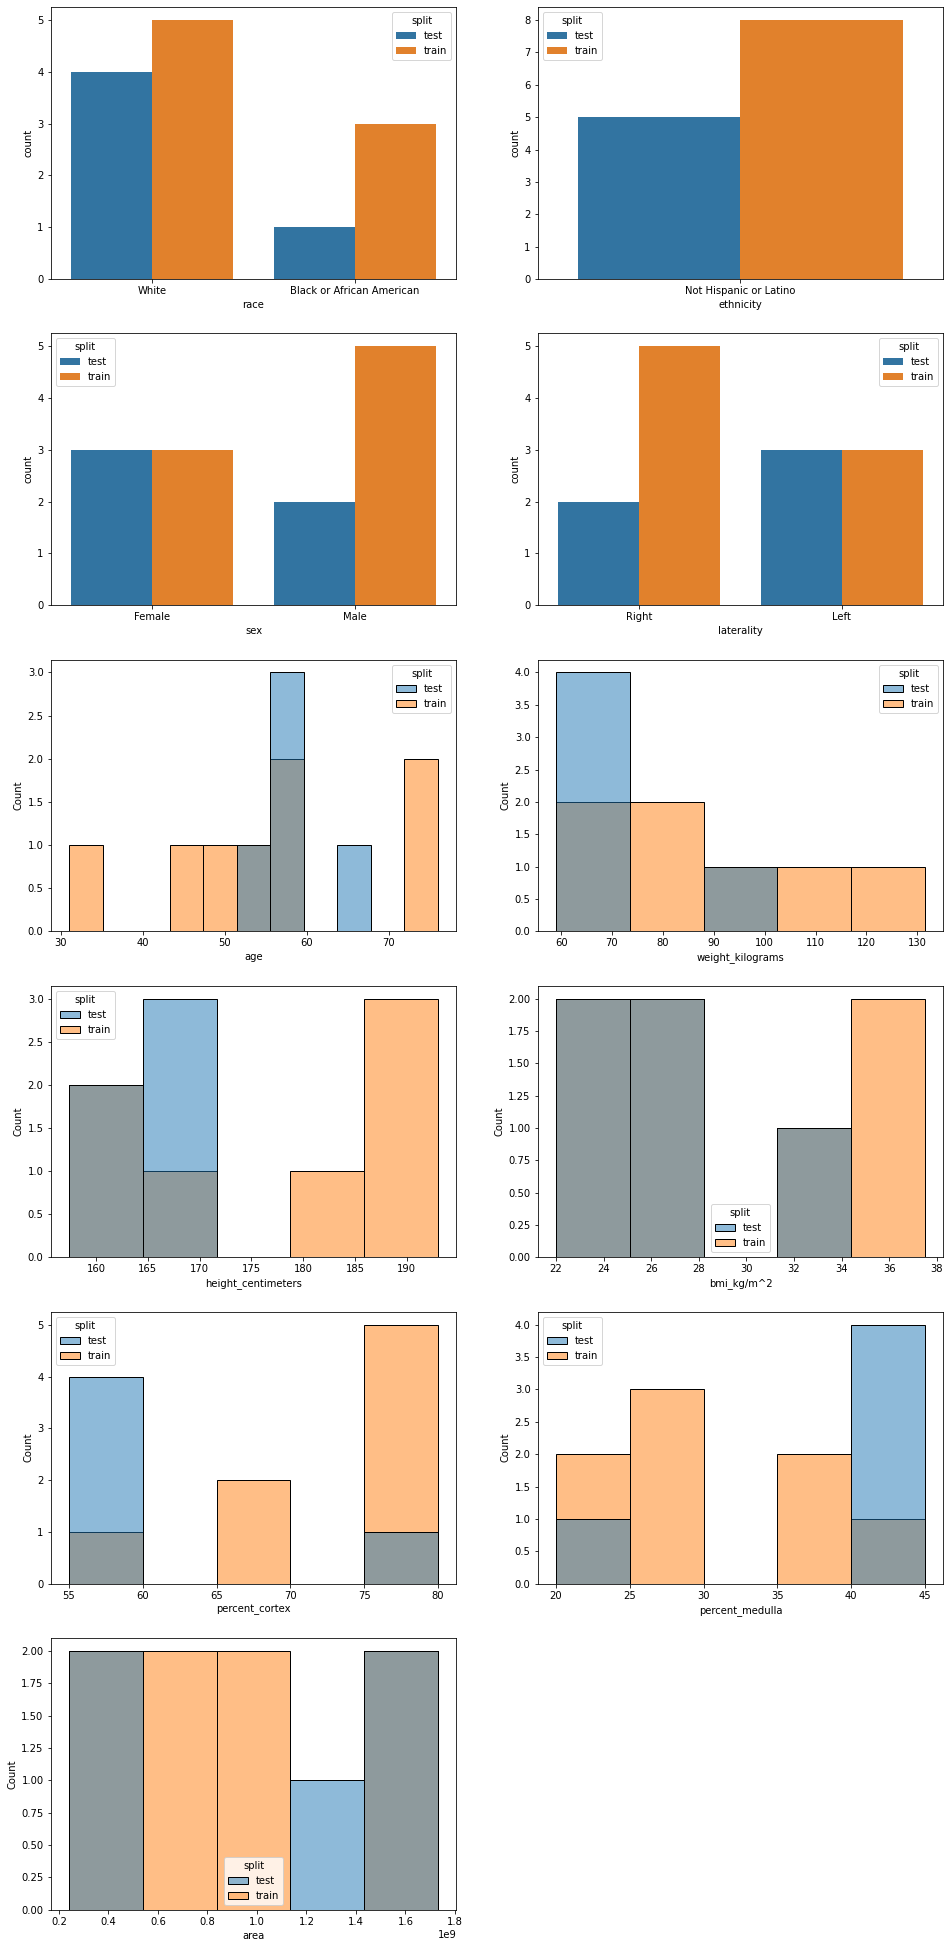

In [25]:
plt.figure(figsize=(16, 35))
plt.subplot(6, 2, 1)
sn.countplot(x="race", hue="split", data=df_info)
plt.subplot(6, 2, 2)
sn.countplot(x="ethnicity", hue="split", data=df_info)
plt.subplot(6, 2, 3)
sn.countplot(x="sex", hue="split", data=df_info)
plt.subplot(6, 2, 4)
sn.countplot(x="laterality", hue="split", data=df_info)
plt.subplot(6, 2, 5)
sn.histplot(x="age", hue="split", data=df_info)
plt.subplot(6, 2, 6)
sn.histplot(x="weight_kilograms", hue="split", data=df_info)
plt.subplot(6, 2, 7)
sn.histplot(x="height_centimeters", hue="split", data=df_info)
plt.subplot(6, 2, 8)
sn.histplot(x="bmi_kg/m^2", hue="split", data=df_info)
plt.subplot(6, 2, 9)
sn.histplot(x="percent_cortex", hue="split", data=df_info)
plt.subplot(6, 2, 10)
sn.histplot(x="percent_medulla", hue="split", data=df_info)
plt.subplot(6, 2, 11)
sn.histplot(x="area", hue="split", data=df_info);